In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels


In [22]:
train = pd.read_csv('YoutubeCommentsDataSet.csv')

In [24]:
print('The train dataset contains {} rows and {} columns.'.format(train.shape[0], train.shape[1]))

The train dataset contains 18408 rows and 2 columns.


In [26]:
print(train.columns)

Index(['Comment', 'Sentiment'], dtype='object')


In [28]:
train.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [30]:
train.tail()

,Comment,Sentiment
18403,i really like the point about engineering tool...,positive
18404,i’ve just started exploring this field and thi...,positive
18405,excelente video con una pregunta filosófica pr...,neutral
18406,hey daniel just discovered your channel a coup...,positive
18407,this is great focus is key a playful approach ...,positive


In [32]:
train.describe(include = 'all').transpose()

,count,unique,top,freq
Comment,18364,17871,one of the best thing about dude is that he ne...,10
Sentiment,18408,3,positive,11432


In [34]:
train.describe()

,Comment,Sentiment
count,18364,18408
unique,17871,3
top,one of the best thing about dude is that he ne...,positive
freq,10,11432


In [36]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB
None


In [38]:
print(train.nunique())

Comment      17871
Sentiment        3
dtype: int64


In [40]:
print(train.isnull().sum())

Comment      44
Sentiment     0
dtype: int64


In [47]:
print(train['Sentiment'].nunique())

3


In [49]:
train['Sentiment'].mode()

0    positive
Name: Sentiment, dtype: object

In [51]:
print(train['Sentiment'].value_counts())

Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64


In [61]:
neutral_response_percentage = train['Sentiment'].value_counts()['neutral']/train['Sentiment'].count()
positive_response_percentage = train['Sentiment'].value_counts()['positive']/train['Sentiment'].count()
negative_response_percentage = train['Sentiment'].value_counts()['negative']/train['Sentiment'].count()
print('Neutral: ', neutral_response_percentage * 100, '%\n',
      'Positive: ', positive_response_percentage * 100, '%\n',
      'Negative: ', negative_response_percentage * 100, '%')


Neutral:  25.19556714471969 %
 Positive:  62.10343328987397 %
 Negative:  12.700999565406345 %


In [65]:
train_positive = train.loc[train['Sentiment'] == 'positive']
train_positive.head()

,Comment,Sentiment
2,i will forever acknowledge this channel with t...,positive
4,apple pay is so convenient secure and easy to ...,positive
6,we only got apple pay in south africa in 20202...,positive
8,in the united states we have an abundance of r...,positive
10,wow you really went to town on the psu test ra...,positive


In [67]:
train_positive.describe()

,Comment,Sentiment
count,11402,11432
unique,11054,1
top,one of the best thing about dude is that he ne...,positive
freq,10,11432


In [69]:
train_negative = train.loc[train['Sentiment'] == 'negative']
train_negative.head()

,Comment,Sentiment
1,here in nz 50 of retailers don’t even have con...,negative
3,whenever i go to a place that doesn’t take app...,negative
14,holy crap i was looking at chroma systems back...,negative
53,how does every person wired brings on this sho...,negative
55,his face when describing hops killed me “some ...,negative


In [71]:
train_negative.describe()

,Comment,Sentiment
count,2337,2338
unique,2317,1
top,honestly i appreciate you and your content tec...,negative
freq,6,2338


In [75]:
train_neutral = train.loc[train['Sentiment'] == 'neutral']
train_neutral.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
5,we’ve been hounding my bank to adopt apple pay...,neutral
7,for now i need both apple pay and the physical...,neutral
9,in cambodia we have a universal qr code system...,neutral
24,linus this is not a table also linus lets use ...,neutral


In [77]:
train_neutral.describe()

,Comment,Sentiment
count,4625,4638
unique,4503,1
top,2323 hermosa elección 18kissxuno los mortales ...,neutral
freq,9,4638


<Axes: xlabel='Sentiment', ylabel='count'>

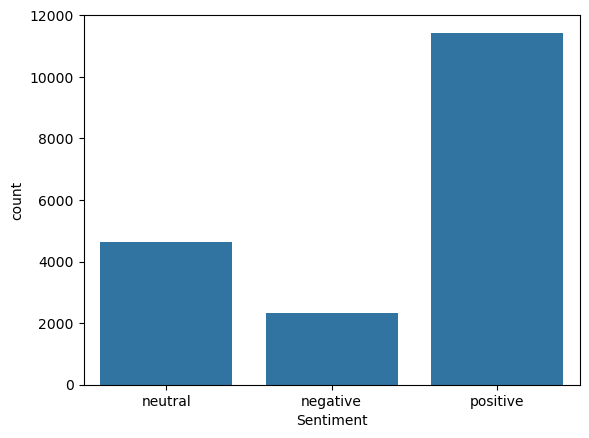

In [79]:
sns.countplot(x = train["Sentiment"])

In [86]:
train.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [98]:
def remove_urls(text):

    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text).replace(' ', ' ')

In [110]:
train['url_removed'] = train['Sentiment'].apply(lambda x: remove_urls(x))
train[['Sentiment', 'url_removed']].tail()

,Sentiment,url_removed
18403,positive,positive
18404,positive,positive
18405,neutral,neutral
18406,positive,positive
18407,positive,positive


In [112]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [128]:
def remove_punctuation(text):

    text = text.translate(str.maketrans('', '', punctuation))
    return text

In [130]:
train['punctuation_removal'] = train['url_removed'].apply(lambda x:remove_punctuation(x))
train[['Sentiment', 'punctuation_removal']].tail()

,Sentiment,punctuation_removal
18403,positive,positive
18404,positive,positive
18405,neutral,neutral
18406,positive,positive
18407,positive,positive


In [138]:
import re
import string

def text_clean(text):
    text = re.sub(r'\[.*?\]', '', text) 
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text) 
    text = re.sub(r'[""''_]', '', text)
    text = re.sub(r'\n', '', text)
    return text


In [147]:
def decontract_text(text):

    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"\'t've", " not have", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'clock", "f the clock", text)
    text = re.sub(r"\'cause", " because", text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\’didn't", " did not", text)
    return text

In [151]:
train['cleaned_description'] = train['punctuation_removal'].apply(lambda x:decontract_text(x))
train['cleaned_description'] = train['cleaned_description'].apply(lambda x:text_clean(x))

In [155]:
print('Original Description:\n', train['Sentiment'][20])
print('Cleaned Description:\n', train['cleaned_description'][20])

Original Description:
 positive
Cleaned Description:
 positive


In [161]:
x, y = train['cleaned_description'], train['Sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1,random_state = 42)
print(f'x_train: {len(x_train)}')
print(f'x_test: {len(x_test)}')
print(f'y_train: {len(y_train)}')
print(f'y_test: {len(y_test)}')
print('Data Spliting is done.')

x_train: 16567
x_test: 1841
y_train: 16567
y_test: 1841
Data Spliting is done.


In [163]:
tvec = TfidfVectorizer()
BNBmodel = BernoulliNB()
model = Pipeline([('vectorizer', tvec), ('classifier', BNBmodel)])
model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', BernoulliNB())])

In [165]:
y_pred = model.predict(x_test)
print(f'Accurcy: {accuracy_score(y_pred, y_test)}')
print(f'Precision: {precision_score(y_pred, y_test, average = "weighted")}')
print(f'Recall: {recall_score(y_pred, y_test, average = "weighted")}')
print(f'f1_score: {f1_score(y_pred, y_test, average = "weighted")}')

Accurcy: 1.0
Precision: 1.0
Recall: 1.0
f1_score: 1.0


In [169]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       231
     neutral       1.00      1.00      1.00       461
    positive       1.00      1.00      1.00      1149

    accuracy                           1.00      1841
   macro avg       1.00      1.00      1.00      1841
weighted avg       1.00      1.00      1.00      1841

[[ 231    0    0]
 [   0  461    0]
 [   0    0 1149]]


In [171]:
testing = ["I am not sure about their services."]
result = model.predict(testing)
print(result)

['positive']
